# MOLE DETECTION

Import Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import time

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight


import keras
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.python.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import TensorBoard

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import cv2

NAME="mole_multiclass-{}".format(int(time.time())) # log file name for tensorboard

Constants

In [3]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'akiec',
    1: 'bcc',
    2: 'bkl',
    3: 'df',
    4: 'mel',
    5: 'nv',
    6: 'vasc'
}
labels = {
    0: 'Actinic keratoses (akiec)',
    1: 'Basal cell carcinoma (bcc)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Dermatofibroma (df)',
    4: 'Melanoma (mel)',
    5: 'Melanocytic nevi (nv)',
    6: 'Vascular lesions (vasc)',
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

SIZE=32  # image size

Read the data and convert labels to integer

In [4]:

data = pd.read_csv('data/HAM10000_metadata.csv')

labele = LabelEncoder()
labele.fit(data['dx'])
data['label'] = labele.transform(data["dx"]) 

print(list(labele.classes_))



['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [5]:
data.dx.value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

## Processing the data
3 different aproaches used
 - 1 class_weights
 - 2 resampling
 - 3 randomoversampling
    

### 1 Class weights

In [ ]:
#Class Weights- this is first option for unbalanced data- did not use it
from sklearn.utils import class_weight
y=data['label'] # you can convert this to integer values 
class_weights = dict(zip(np.unique(y), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y), 
                y=y))) 
class_weights

### 2 -Resampling with sklearn 

In [83]:
#resampling- second option for unbalanced data- 
n_samples=500

from sklearn.utils import resample
print(data['label'].value_counts())

# Balancing the data
# tried balancing with class weights and imageprocessing best results came with randomoversampling

df_0 = data[data['label'] == 0]
df_1 = data[data['label'] == 1]
df_2 = data[data['label'] == 2]
df_3 = data[data['label'] == 3]
df_4 = data[data['label'] == 4]
df_5 = data[data['label'] == 5]
df_6 = data[data['label'] == 6]


df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
data_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

print(data_balanced['label'].value_counts())
data=data_balanced.copy(deep=True)
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


### 3 -Random Over Sampling 

In [9]:
# Before using this part it is better to run Removing hair from mole images functions Because of oversampling it can take double the amount of time
ros = RandomOverSampler()
x=data
y=data['label']
data,y=ros.fit_resample(x, y)
data['label'].value_counts()

2    6705
5    6705
3    6705
4    6705
6    6705
1    6705
0    6705
Name: label, dtype: int64

## Removing hair from mole images

In [6]:
data['path'] = './data/HAM10000_images/' + data['image_id'] +".jpg"
hair_images=data['path']

In [7]:
def shave_the_mole(image):
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1,(3,3))
    blackhat = cv2.morphologyEx(grayscale, cv2.MORPH_BLACKHAT, kernel)
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    shaved_mole = cv2.inpaint(image,threshold,5,cv2.INPAINT_TELEA)
    return shaved_mole

In [8]:

features_list=[]
for i,image_name in enumerate(hair_images[0:hair_images.size]):
    image = cv2.imread(hair_images[i])
    image_resize = cv2.resize(image,(SIZE,SIZE))
    shaved_image = shave_the_mole(image_resize)
    
    final_image=cv2.cvtColor(shaved_image, cv2.COLOR_BGR2RGB)
    features_list.append(final_image)
    
data['image']=features_list  

#### Show cleaned images

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=20).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)


In [10]:
# take a copy to check other things
data1=data.copy(deep=True)


In [85]:
data=data1

## Create Model 

In [11]:
#Convert dataframe column of image data to array

X = np.asarray(data['image'].tolist())
X = X/255. 
Y=data['label']  #
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical 
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42,shuffle=True)


Clean the memory

In [ ]:
import gc
import pandas as pd

del [[data,features_list,hair_images]]
gc.collect()
data=pd.DataFrame()



### Model

In [16]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.CategoricalCrossentropy(name='ccent'),
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
   
      keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
     # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
#model.add(Dense(len(train_generator.classes), activation='softmax'))

model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=[METRICS])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 256)       7168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 256)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 15, 256)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 128)       295040    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 128)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 6, 6, 128)        

#### Defining callbacks and fitting the model

In [17]:

early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
tensorboard=TensorBoard(log_dir='./logs/{}'.format(NAME)) ## logs are under logs folder for tensorboard
                            
batch_size = 32 
epochs = 40

learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

history = model.fit(x_train, y_train, validation_split=0.2, batch_size = batch_size, 
                     epochs = epochs,callbacks = [learning_rate, early_stop, tensorboard])


# If you choosed to use class weight:
# history = model.fit(x_train, y_train, validation_split=0.2, batch_size = batch_size, class_weight=class_weights,
#                      epochs = epochs,callbacks = [learning_rate, early_stop, tensorboard])

Epoch 1/40
939/939 [==============================] - 21s 21ms/step - loss: 1.5278 - accuracy: 0.3781 - precision: 0.7447 - ccent: 1.5278 - recall: 0.1443 - val_loss: 1.2691 - val_accuracy: 0.4985 - val_precision: 0.7985 - val_ccent: 1.2691 - val_recall: 0.2221 - lr: 0.0010
Epoch 2/40
939/939 [==============================] - 19s 20ms/step - loss: 1.2373 - accuracy: 0.5189 - precision: 0.7591 - ccent: 1.2373 - recall: 0.2760 - val_loss: 1.0956 - val_accuracy: 0.5940 - val_precision: 0.8271 - val_ccent: 1.0956 - val_recall: 0.3071 - lr: 0.0010
Epoch 3/40
939/939 [==============================] - 19s 20ms/step - loss: 1.1209 - accuracy: 0.5711 - precision: 0.7503 - ccent: 1.1209 - recall: 0.3643 - val_loss: 0.9668 - val_accuracy: 0.6431 - val_precision: 0.8081 - val_ccent: 0.9668 - val_recall: 0.4105 - lr: 0.0010
Epoch 4/40
939/939 [==============================] - 19s 21ms/step - loss: 1.0192 - accuracy: 0.6129 - precision: 0.7601 - ccent: 1.0192 - recall: 0.4433 - val_loss: 0.9228 -

#### Evaluating Model

294/294 [==============================] - 3s 11ms/step - loss: 0.2702 - accuracy: 0.9076 - precision: 0.9412 - ccent: 0.2702 - recall: 0.8704
Accuracy: 0.9076382517814636


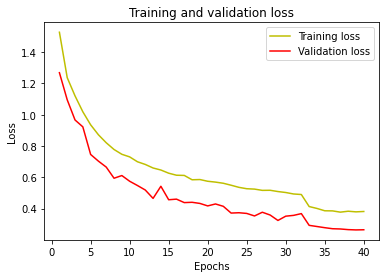

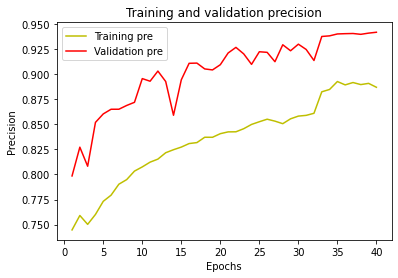

In [18]:
score = model.evaluate(x_test, y_test)
print('Accuracy:', score[1])


#Plot the training and validation accuracy and loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['precision']
val_acc = history.history['val_precision']
plt.plot(epochs, acc, 'y', label='Training pre')
plt.plot(epochs, val_acc, 'r', label='Validation pre')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

Calssification report and Confusion matrix

294/294 [==============================] - 2s 5ms/step
[[1287    8    0    0    0    0    0]
 [   0 1315    3    0    4    1    0]
 [  30   75 1179    3   41   23    0]
 [   0    0    0 1392    0    0    0]
 [  14   15  135    0 1052   94    2]
 [  19   49  144    6  188  927   13]
 [   0    0    0    0    0    0 1368]]
                                     precision    recall  f1-score   support

          Actinic keratoses (akiec)       0.95      0.99      0.97      1295
         Basal cell carcinoma (bcc)       0.90      0.99      0.94      1323
Benign keratosis-like lesions (bkl)       0.81      0.87      0.84      1351
                Dermatofibroma (df)       0.99      1.00      1.00      1392
                     Melanoma (mel)       0.82      0.80      0.81      1312
              Melanocytic nevi (nv)       0.89      0.69      0.78      1346
            Vascular lesions (vasc)       0.99      1.00      0.99      1368

                           accuracy                         

<AxesSubplot:>

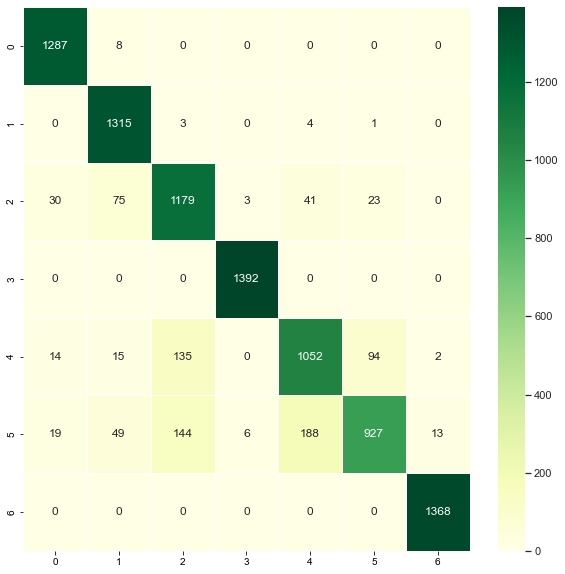

In [19]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 


#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)
#Print classification_report
print(classification_report(y_true, y_pred_classes,target_names=labels.values()))
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax,fmt='g',cmap="YlGn")

Incorrect classifications

Text(0, 0.5, 'Percent of incorrect predictions')

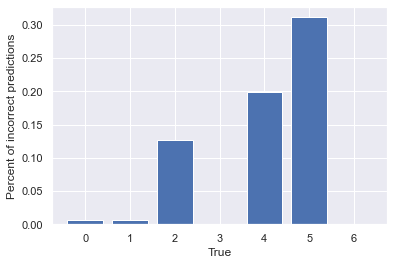

In [20]:
incorr = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr)
plt.xlabel('True')
plt.ylabel('Percent of incorrect predictions')

### Save the model and weights

In [ ]:
model_json = model.to_json()
with open("./model/modelmk.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("./model/modelmk.h5")

----------